In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

import nltk
import string 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


In [4]:
df = pd.read_csv('/Users\JAYSHREE RATHOD\Downloads/Final_data_submit (1).csv') #content based filtering
df1 = df[['Name','Description','Rating','Timing','Address','Spend Up Time','Tags']]
df1['Tags'] = df1['Tags'].fillna(' ')
df1['Tags'].replace(' ',np.NaN)
def remove_punc(text):
    text = text.replace(',', ' ')
    return text
df1['Tags'] = df1['Tags'].astype(str).apply(lambda x : remove_punc(x))
vectorizer = CountVectorizer()
def Decription_cleaning(Decription):
    test_punc_removed = [char   for char in Decription if char not in string.punctuation]
    test_punc_removed_join = ''.join(test_punc_removed)
    test_punc_removed_join_stp = [word    for word in test_punc_removed_join.split() if word.lower() not in stopwords.words('english') ]
    return str(test_punc_removed_join_stp)
df_clean = df['Description'].apply(Decription_cleaning)
remove_punc(df_clean)
df1['cleaned_des'] = df_clean
df1['combined'] = df1['Tags'] + df1['cleaned_des']
df1['combined'] = df1['combined'].fillna('')
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df1['combined'])
ind=pd.Series(df1.index, index=df1["Name"]).drop_duplicates()
tfidf_matrix = tf.fit_transform(df1['combined'])
cos_tag=cosine_similarity(tfidf_matrix,tfidf_matrix)
def give_rec_tag(park_name, sig=cos_tag):
    idx = ind[park_name]
    sig_scores = list(enumerate(sig[idx]))
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
    sig_scores = sig_scores[1:31]
    indi= [i[0] for i in sig_scores]
    return df1.iloc[indi]
park_name = ['Stanley Park']
x = []
for i in range(len(park_name)):
  df3 = give_rec_tag(park_name[i],sig=cos_tag)
  x.extend(list(df3.Name))
z = x
boo3 = df.Name.isin(z)
df3 =df[boo3]
df3 =df3.sort_values(by = 'Rating', ascending= False)
df3 = df3.reset_index()
result1 = list(df3.Name)


# Surprise


In [20]:
import surprise
from surprise import Dataset, Reader
from surprise.similarities import pearson, pearson_baseline
from surprise.prediction_algorithms.knns import KNNBaseline
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate
from surprise import accuracy
import numpy as np
park_df = pd.read_csv('/Users\JAYSHREE RATHOD\Downloads/parks_dummy.csv')

reader = Reader(line_format='user item rating', sep=',', rating_scale = (1,10))
tot_data = Dataset.load_from_df(park_df[["user_id", "park_id", "rating"]], reader=reader)

In [22]:
trainset, testset = train_test_split(tot_data, test_size=0.2)

trainset_iids = list(trainset.all_items())
iid_converter = lambda x: trainset.to_raw_iid(x)
trainset_raw_iids = list(map(iid_converter, trainset_iids))

In [23]:
trainsetfull = tot_data.build_full_trainset() #Do not split the dataset into folds and just return a trainset as
                                                # it is, built from the whole dataset.

In [25]:
trainsetfull_iids = list(trainsetfull.all_items()) #Built-in mutable sequence
iid_converter = lambda x: trainsetfull.to_raw_iid(x)
trainsetfull_raw_iids = list(map(iid_converter, trainsetfull_iids)) 

In [40]:
sim_options = {"name":"pearson", "user_based":False}

In [41]:
def return_top_similar_dataframe(similarity_matrix, raw_ids, top_x):
    length = similarity_matrix.shape[0]
    closest_ids = np.zeros((top_x,length))
    for item in range(0,length):    
        similarity_metrics = similarity_matrix[item]        
        sorted_metrics, sorted_raw_ids = zip(*sorted(zip(similarity_metrics, raw_ids)))        
        for index in range(0, top_x):
            closest_ids[index][item] = sorted_raw_ids[-2-index]
        similarity_df = pd.DataFrame()
        similarity_df['park_id'] = raw_ids
        for index in range(0, top_x): 
            similarity_df['similar_park_' + str(index + 1)] = closest_ids[index].astype(int)
    return similarity_df

id_to_name_dict = {}
park_names = park_df["park_name"]
park_ids = park_df["park_id"]
for index in range(0, len(park_ids)):
    id_to_name_dict[str(park_ids[index])] = park_names[index]

def get_park_name_from_id(park_id):
    return id_to_name_dict[str(park_id)]
def save_similar_park(similarity_matrix, raw_iids, top_x):
    sim_df = return_top_similar_dataframe(similarity_matrix, raw_iids, top_x)
    for column in sim_df.columns:
        for i in range(len(sim_df[column])):
            sim_df[column][i] = get_park_name_from_id(sim_df[column][i])
    return sim_df

In [43]:
model1 = KNNBasic(sim_options = sim_options, verbose = False) #Estimating biases using sgd.
model1.fit(trainsetfull)
model2 = KNNWithMeans(sim_options = sim_options, verbose = False)#Computing the pearson similarity matrix
model2.fit(trainsetfull)
model3 = KNNBaseline(k = 10, sim_options = sim_options, bsl_options = {"method":"sgd","learning_rate":0.00006})
model3.fit(trainsetfull)
sim_basic_df = save_similar_park(model1.sim, trainsetfull_raw_iids, 10)
sim_means_df = save_similar_park(model2.sim, trainsetfull_raw_iids, 10)
sim_base_df = save_similar_park(model3.sim, trainsetfull_raw_iids, 10)

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [47]:
results_basic = cross_validate(model1, tot_data, measures=['RMSE'], cv=3, return_train_measures=True)
results_means = cross_validate(model2, tot_data, measures=['RMSE'], cv=3, return_train_measures=True)
results_base = cross_validate(model3, tot_data, measures=['RMSE'], cv = 3, return_train_measures=True)

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [48]:
park_name = ["Stanley Park","Capilano Suspension Bridge Park","Beacon Hill Park"]
result2 = []
for i in range(len(park_name)):
    if park_name[i] in list(park_names):
        rec3 = sim_basic_df[sim_basic_df["park_id"] == park_name[i]]
        result2.extend(list(rec3.iloc[0, 1:]))


# Running the Deep learning model and evaluating it¶

In [51]:
import keras
from keras.layers import Embedding, Reshape,Concatenate,Add
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import dot

from keras.layers import *
from keras.models import Model
from keras.layers import concatenate

In [52]:
ratings = pd.read_csv('/Users\JAYSHREE RATHOD\Downloads/parks_dummy.csv', usecols = ["user_id", "park_id","rating","park_name"]) 
ratings.user_id = ratings.user_id.astype('category').cat.codes.values
ratings.park_id = ratings.park_id.astype('category').cat.codes.values
train, test = train_test_split(ratings, test_size=0.2)
n_users, n_park = len(ratings.user_id.unique()), len(ratings.park_id.unique())

In [54]:
def neural_network_model(n_latent_factors_user, n_latent_factors_park):
    
    park_input = keras.layers.Input(shape=[1],name='Item')
    park_embedding = keras.layers.Embedding(n_park + 1, n_latent_factors_park, name='park-Embedding')(park_input)
    park_vec = keras.layers.Flatten(name='Flattenpark')(park_embedding)
    pak_vec = keras.layers.Dropout(0.2)(park_vec)


    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
    user_vec = keras.layers.Dropout(0.2)(user_vec)

    concat =keras.layers.merge.concatenate([park_vec, user_vec],name='Concat')
    concat_dropout = keras.layers.Dropout(0.2)(concat)
    dense = keras.layers.Dense(100,name='FullyConnected')(concat)
    dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
    dense_2 = keras.layers.Dense(50,name='FullyConnected-1')(concat)
    dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
    dense_3 = keras.layers.Dense(20,name='FullyConnected-2')(dense_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
    dense_4 = keras.layers.Dense(10,name='FullyConnected-3', activation='relu')(dense_3)


    result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
    adam = Adam(lr=0.005)
    model = keras.Model([user_input, park_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error', metrics = ["MAE"])
    return model

In [55]:
model3 = neural_network_model(100,180)
history_neural_network = model3.fit([train.user_id, train.park_id], train.rating, epochs=50, verbose=0)

In [56]:
park_embedding_learnt = model3.get_layer(name='park-Embedding').get_weights()[0]
user_embedding_learnt = model3.get_layer(name='User-Embedding').get_weights()[0]

In [61]:
#choose a user ID
user_id = 21
#get movies rated by this user id
users_park = ratings.loc[ratings["user_id"]==user_id]
#print how many ratings user has made 
#print("User ID : " + str(user_id) + " has already rated " + str(len(users_park)) + " park")
#list movies that have been rat
#print(users_park)

mf_pred = pd.DataFrame(user_embedding_learnt)
mf_pred.head()
user_index = train.loc[train["user_id"]==user_id]['user_id'][:1].values[0]
#print(user_index)
#get movie ratings predicted for this user and sort by highest rating prediction
sorted_user_predictions = pd.DataFrame(mf_pred.iloc[user_index].sort_values(ascending=False))
#rename the columns
sorted_user_predictions.columns=['Ratings']
#save the index values as res id
sorted_user_predictions['park_id']=sorted_user_predictions.index
#print("Top 10 predictions for User " + str(user_id))
#display the top 10 predictions for this user
#print(sorted_user_predictions)
topn3 = pd.merge(sorted_user_predictions,ratings)
#df_names = pd.merge(ratings,Restaurant_list,left_on='Restaurant_id',right_on='resId')
topn4 = topn3.drop_duplicates(subset = 'park_name', keep='first', inplace=False)[:10]


In [62]:
seed = 7
np.random.seed(seed)
#dataset = numpy.loadtxt("res3.csv", delimiter=",")
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
scores = model3.evaluate([test.user_id, test.park_id], test.rating, verbose=0)
cvscores.append(scores*100)
#print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))
def matrix_factorisation_model_with_n_latent_factors_and_non_negative_embedding(n_latent_factors) :
    park_input = keras.layers.Input(shape=[1],name='Item')
    park_embedding = keras.layers.Embedding(n_park + 1, n_latent_factors, name='Non-Negative-park-Embedding')(park_input)
    park_vec = keras.layers.Flatten(name='Flattenres')(park_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='Non-Negative-User-Embedding')(user_input))
    prod =dot([park_vec, user_vec], axes=1, normalize=False,name='DotProduct')
    
    model = keras.Model([user_input, park_input], prod)
    #print(model)
    model.compile('adam', 'mean_squared_error')
    
    return model

In [64]:
model2 = matrix_factorisation_model_with_n_latent_factors_and_non_negative_embedding(10)
history_nonneg = model2.fit([train.user_id, train.park_id], train.rating, epochs=10, verbose=0)
park_embedding_learnt_2 = model2.get_layer(name = "Non-Negative-park-Embedding").get_weights()[0]
user_embedding_learnt_2 = model2.get_layer(name = "Non-Negative-User-Embedding").get_weights()[0]
mf_pred_2 = pd.DataFrame(user_embedding_learnt_2)
user_index = train.loc[train["user_id"]==user_id]['user_id'][:1].values[0]
#print(user_index)
#get movie ratings predicted for this user and sort by highest rating prediction
sorted_user_predictions = pd.DataFrame(mf_pred_2.iloc[user_index].sort_values(ascending=False))
#rename the columns
#print(sorted_user_predictions)
sorted_user_predictions.columns=['ratings']
#save the index values as res id
sorted_user_predictions['park_id']=sorted_user_predictions.index
#print("Top 10 predictions for User " + str(user_id))
#display the top 10 predictions for this user
#print(sorted_user_predictions)
topn2 = pd.merge(sorted_user_predictions,ratings)
#df_names = pd.merge(ratings,Restaurant_list,left_on='Restaurant_id',right_on='resId')
topn2 = topn2.drop_duplicates(subset = 'park_name', keep='first', inplace=False)[:31]
seed = 10
np.random.seed(seed)
#dataset = numpy.loadtxt("res3.csv", delimiter=",")
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
scores = model2.evaluate([test.user_id, test.park_id], test.rating, verbose=0)
cvscores.append(scores*100)
#print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

In [65]:
result3 = list(topn2.park_name)
result = {}
if len(result3) == 0:
  p = list(set(result1+result2))
  for i in p:
    if i in result1 and i in result2:
      x = result1.index(i)
      y = result2.index(i)
      t = (0.6 * x) + (0.4 * y)
    elif i in result1:
      x = result1.index(i)
      t = 0.6 * x
    elif i in result2:
      y = result2.index(i)
      t = 0.4 * y

    result[t] = i
else:
  p = list(set(result1+result2))
  for i in p:
    x = 0
    y = 0
    z = 0
    if i in result1:
      x = result1.index(i)
    if i in result2:
      y = result2.index(i)
    
    if i in result3:
      z = result3.index(i)
    
    t = (0.3 * x) + (0.4 * y) + (0.3 * z)
    result[t] = i
x = sorted(list(result.keys()))
results = [result[x[i]] for i in range(len(x))]
final = results[:10]


# CPU Time calcuation

In [73]:
#!/usr/bin/env python
import psutil
# gives a single float value
per = psutil.cpu_percent()
print(per)
# gives an object with many fields
psutil.virtual_memory()
# you can convert that object to a dictionary 
print(dict(psutil.virtual_memory()._asdict()))
# you can have the percentage of used RAM
ram_used = psutil.virtual_memory().percent
print(ram_used)
# you can calculate percentage of available memory
psutil.virtual_memory().available * 100 / psutil.virtual_memory().total



14.3
{'total': 8500957184, 'available': 3587084288, 'percent': 57.8, 'used': 4913872896, 'free': 3587084288}
57.8


42.196239909917416

In [77]:
%matplotlib inline
from matplotlib.animation import FuncAnimation
from psutil import cpu_percent

Traceback (most recent call last):
  File "C:\Users\JAYSHREE RATHOD\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "C:\Users\JAYSHREE RATHOD\anaconda3\lib\site-packages\matplotlib\animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [78]:
cpu_percent()

12.7

<IPython.core.display.Javascript object>


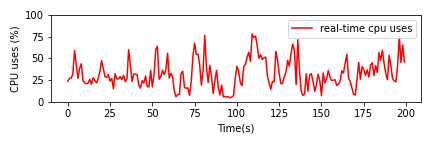

In [79]:
%matplotlib notebook
y = []
frame_len = 200
fig = plt.figure(figsize=(6,2))
def animate(i):
    y.append(cpu_percent())
    
    if len(y) <= frame_len:
        plt.cla()
        plt.plot(y,'r',label = 'real time cpu uses')
    else:
        plt.cla()
        plt.plot(y[-frame_len:],'r',label = 'real-time cpu uses')
    plt.ylim(0,100)
    plt.xlabel('Time(s)')
    plt.ylabel('CPU uses (%)')
    plt.legend(loc = 'upper right')
    plt.tight_layout()

ani = FuncAnimation(plt.gcf(),animate,interval=1000) 
ani